In [1]:
import numpy as np
import torch
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf
chr_list = abf.getChrList()

date = '7_21_20' # Change this to today's date for output names.

input_dir = '../tensor_input/' # directory with the HOSVD results
file_prefix = 'leiomyoma_HOSVD_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
# The genomic bins used for the hg19 genome. chr Y is
# the last chromosome in the list, so the ordering of 
# the bins through chrX is the same as that when 
# chr Y is removed.

chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [3]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1]), int(l[0].split(',')[2])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_pt = 21
n_as = 3
n_gr = 2
fp.close()

sample_proj = np.zeros((n_gr, n_pt, n_as, len(projections)))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1], index[k][2]] = projections[k]

126 126


In [4]:
# Read the HOSVD location vectors.
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_location.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]
print(U_l.shape)

(1518186, 126)


In [5]:
# ANOVA analysis to identify location vectors that separate the 
# conditions (leiomyoma/myometrium).
n_loc = len(U_l[0,:])
full_var_ratio = np.zeros(n_loc)
wGroupVar = np.zeros((n_as, n_loc))
bGroupVar = np.zeros((n_as, n_loc))

for l in range(n_loc):
    for k in range(n_as):
        bGroupVar[k,l] = n_pt*(np.mean(sample_proj[0,:,k,l]) - np.mean((sample_proj[:,:,k,l])))**2 +\
                         n_pt*(np.mean(sample_proj[1,:,k,l]) - np.mean((sample_proj[:,:,k,l])))**2
        wGroupVar[k,l] = sum( np.power(sample_proj[0,:,k,l] - np.mean(sample_proj[0,:,k,l]),2) ) +\
                         sum( np.power(sample_proj[1,:,k,l] - np.mean(sample_proj[1,:,k,l]),2) )
    full_var_ratio[l] = (sum(bGroupVar[:,l])/(n_as*(n_gr-1)))/(sum(wGroupVar[:,l])/(n_as*(n_gr*n_pt - n_gr)))

print(np.argsort(full_var_ratio)[-10:])

# This statistic is only F-distributed if the assays are independent.
print(1 - scipy.stats.f.cdf(max(full_var_ratio),
                            n_as*(n_gr-1), n_as*n_gr*(n_pt-1),
                            loc=0, scale=1))

[ 2 19 15 11  8  1  9 10 12  3]
1.1102230246251565e-16


In [6]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# the conditions.

# Select the mode with greatest between condition separation.
l = np.argmax(full_var_ratio)

# Set the threshold for a vector component to be considered significant.
# The empirical distribution of component values from all vectors is used
# to set the threshold.

cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')

significant_pos = []
significant_neg = []
for i in range(L_genome):
    if(U_l[i,l] > cut):
        significant_pos.append(i)
    elif(U_l[i,l] < -cut):
        significant_neg.append(i)
        
print(len(significant_pos), 'positive')
print(len(significant_neg), 'negative')

1306 positive
1818 negative


In [7]:
# Get the projections of the data onto the condition 
# and assay space decompositions.
import tensorly
tensorly.set_backend('pytorch')
S = torch.load(input_dir + 'leiomyoma_HOSVD_final_core_tensor.pt')
U_pt = torch.load(input_dir + 'leiomyoma_HOSVD_final_factor_matrix_patient.pt')

proj_ac = tensorly.tenalg.mode_dot(S, U_pt, 1)
proj_ac = tensorly.tenalg.mode_dot(proj_ac, torch.tensor(U_l), 3)
del S, U_pt
print(proj_ac.shape)

Using numpy backend.
Using pytorch backend.


torch.Size([2, 21, 3, 1518186])


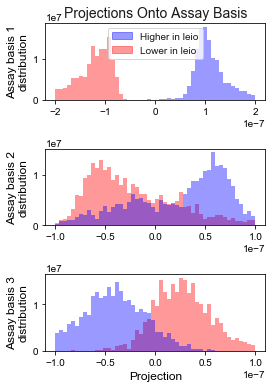

In [8]:
# For the regions found to exhibit epigenetic alterations
# between leiomyoma and myometrium, plot the patient mean
# projection onto each of the three assay space basis 
# vectors while holding the condition space basis vector 
# fixed to that describing differences between leiomyoma 
# and myometrium.
legend_assay_vecs = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,0.4), (1,0,0,0.4)], ['Higher in leio', 'Lower in leio'])]

fig = plt.figure(figsize=(4.0,5.5), edgecolor='k')

assay_name = ['H3K27ac', 'H3K4me3', 'H3K4me1']
bound = [2*10**-7, 1*10**-7, 1*10**-7]

for k in range(n_as):
    assay = k
    ax = fig.add_subplot(311+k, frame_on=True)
    hist_u = plt.hist(np.mean(proj_ac[1, :, k].numpy(),axis=0)[significant_pos],
                 bins=50, color=(1, 0, 0, .4), range=(-bound[k],bound[k]), density=True)
    hist_d = plt.hist(np.mean(proj_ac[1, :, k].numpy(),axis=0)[significant_neg],
                 bins=50, color=(0, 0, 1, .4), range=(-bound[k],bound[k]), density=True)
    if(k == 0):
        plt.title('Projections Onto Assay Basis',fontsize=14)
        ax.legend(handles=legend_assay_vecs,
                       frameon=True, fontsize=10, ncol=1)
        
    ax.set_ylabel('Assay basis ' + str(k+1) + '\ndistribution', fontsize=12)
    if(k == n_as-1):
        ax.set_xlabel('Projection',fontsize=12)
plt.tight_layout()

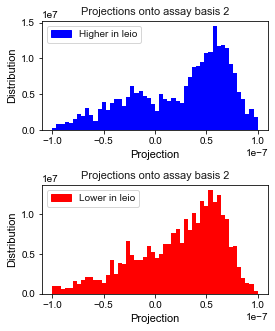

In [9]:
# Figure 3A: Plot the patient mean projection onto
# the second assay space basis vector for the regions
# found to have higher (top) lower (bottom) activating
# histone modifications in leiomyoma

legend_assay_vecs_up = [mpatches.Patch(color=c, label=l) for c,l in zip([(1,0,0,1)], ['Lower in leio'])]
legend_assay_vecs_down = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1)], ['Higher in leio'])]

fig = plt.figure(figsize=(4.0,4.7), edgecolor='k')

ax = fig.add_subplot(211)

hist_d = plt.hist(np.mean(proj_ac[1, :, 1].numpy(),axis=0)[significant_neg],
             bins=50, color=(0,0,1,1), range=(-10**-7,10**-7), density=True)

plt.title('Projections onto assay basis 2',fontsize=11)
ax.legend(handles=legend_assay_vecs_down,
                frameon=True, fontsize=10, ncol=1)
ax.set_ylabel('Distribution', fontsize=11)
ax.set_xlabel('Projection',fontsize=11)
plt.tight_layout()

ax = fig.add_subplot(212)

# Flip the sign here to make the interpretation of the 
# x-axis consistent. This way more negative values indicate
# more H3K4me3 in the respected condition.
hist_u = plt.hist(-1.0*np.mean(proj_ac[1, :, 1].numpy(),axis=0)[significant_pos],
             bins=50, color=(1,0,0,1), range=(-10**-7,10**-7), density=True)

plt.title('Projections onto assay basis 2',fontsize=11)
ax.legend(handles=legend_assay_vecs_up,
                frameon=True, fontsize=10, ncol=1)
ax.set_ylabel('Distribution', fontsize=11)
ax.set_xlabel('Projection',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figure3_panels/' + file_prefix +
            '_panelA_assay_basis_2_projection_distribution_' + date + '.pdf',
            bbox_inches='tight', transparent=True, format='pdf')

In [10]:
# Sort the genomic bins by the corresponding component
# value in the differential location vector, and separate
# the regions into promoters and enhancers.
loc_order = np.argsort(U_l[:,np.argmax(full_var_ratio)])
base_line = 0.0 
print(base_line)
# Get the mean projection across patients onto the seocond
# basis vector of the assay space and the second basis
# vector of the condition space.
mean_values = np.mean(proj_ac[1, :, 1].numpy(),axis=0)

# Use the baseline value to characterize the bins as
# prommoters or enhancers.
char_index_order = [[], [], [], []]
char_colors = [[], [], [], []]
# Regions with higher activating histone marks
# in leiomyoma.
for l in range(len(significant_neg)):
    if(mean_values[loc_order[l]] < base_line):
        char_colors[0].append('k')
        char_index_order[0].append(loc_order[l])
    else:
        char_colors[1].append((0.6, 0.6, 0.6))
        char_index_order[1].append(loc_order[l])

# Regions with lower activating histone marks
# in leiomyoma.
for l in range(len(significant_pos)):
    if(mean_values[loc_order[-l-1]] > base_line):
        char_colors[2].append((125/255, 30/255, 125/255))
        char_index_order[2].append(loc_order[-l-1])
    else:
        char_colors[3].append((245/255, 179/255, 245/255))
        char_index_order[3].append(loc_order[-l-1])
    
# Concatenate the regions and color labels into a single list
# for plotting.
functional_order = char_index_order[0] + char_index_order[1] + char_index_order[2] + char_index_order[3]
functional_color = char_colors[0] + char_colors[1] + char_colors[2] + char_colors[3]

0.0


In [11]:
# Load the scaled data tensor to plot the condition difference
# in histone modifications at the differential regions.
t = torch.load(input_dir + file_prefix + '_scaled_tensor.pt')

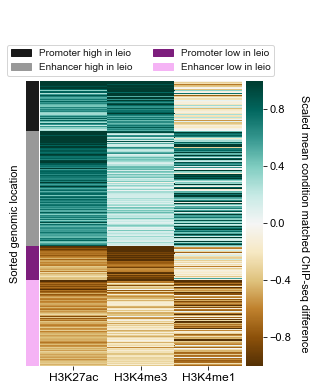

In [12]:
# Figure 3B: The patient mean difference in the histone modification
# ChIP-seq signal between the two conditions. The bins are sorted
# by the corresponding component values on the differential HOSVD
# location vector and grouped into functional classes.

regulatory_colors = ['k', (0.6, 0.6, 0.6), (125/255, 30/255, 125/255),
                     (245/255, 179/255, 245/255)]
regulatory_labels = ['Promoter high in leio', 'Enhancer high in leio',
                     'Promoter low in leio', 'Enhancer low in leio']
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip(regulatory_colors, regulatory_labels)]

# Get the patient mean difference in ChIP-seq signal between the two
# conditions for each of the assays.
end_regions = np.column_stack((np.mean(t[1,:,0,:].numpy(), axis=0) - np.mean(t[0,:,0,:].numpy(), axis=0),
                               np.mean(t[1,:,1,:].numpy(), axis=0) - np.mean(t[0,:,1,:].numpy(), axis=0),
                               np.mean(t[1,:,2,:].numpy(), axis=0) - np.mean(t[0,:,2,:].numpy(), axis=0)))

# Extract the signal at the differential regions using the ordering
# described above.
end_regions = end_regions[functional_order, :]

max_scale = [np.percentile(np.abs(end_regions)[:,k], 90, interpolation='nearest') for k in range(3)]

end_regions[:,0] = np.divide(end_regions[:,0], max_scale[0])
end_regions[:,1] = np.divide(end_regions[:,1], max_scale[1])
end_regions[:,2] = np.divide(end_regions[:,2], max_scale[2])

g = seaborn.clustermap(end_regions, row_cluster=False, col_cluster=False, cmap="BrBG",
                       row_colors=functional_color, center = 0.0, vmin = -1.0, vmax= 1.0,
                       xticklabels = ['H3K27ac' , 'H3K4me3', 'H3K4me1'], yticklabels=[],
                       figsize=(4.8, 6.6))

g.ax_row_dendrogram.set_visible(False)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=12)

g.cax.set_position([0.91,0.125,0.05,0.60])
plt.setp(g.cax.get_yticklabels(), fontsize=11)
g.cax.set_ylabel('Scaled mean condition matched ChIP-seq difference', rotation=270, fontsize=11, labelpad=17)

g.ax_heatmap.yaxis.set_label_position("left")

l2=g.ax_heatmap.legend(loc='lower center', bbox_to_anchor=(0.45, 1.0, 0.1, 0.1), handles=legend_TN,
                       frameon=True, fontsize=10, ncol=2)

g.ax_heatmap.set_ylabel('Sorted genomic location', fontsize=11, labelpad=20)

# plt.savefig(output_dir + 'figures/' + 'figure3_panels/' + file_prefix +
#             '_panelB_sorted_location_functional_heatmap_' + date + '.png',
#             bbox_inches='tight', dpi=300, transparent=True, format='png')

plt.savefig(output_dir + 'figures/' + 'figure3_panels/' + file_prefix +
            '_panelB_sorted_location_functional_heatmap_' + date + '.pdf',
            bbox_inches='tight', transparent=True, format='pdf')

In [13]:
## Write the enhancer and promoter regions into separate bed files

base_line = 0.0
print(base_line)
mean_values = np.mean(proj_ac[1, :, 1].numpy(),axis=0)

output_up = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(np.argmax(full_var_ratio)+1) + '_promoter.bed','w+')

for l in range(0,len(significant_pos)):
    if(mean_values[significant_pos[l]] > base_line):
        output_up.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0],genomic_bin[significant_pos[l]][1],genomic_bin[significant_pos[l]][2]))     
output_up.close()

output_up = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(np.argmax(full_var_ratio)+1) + '_enhancer.bed','w+')

for l in range(0,len(significant_pos)):
    if(mean_values[significant_pos[l]] < base_line):
        output_up.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0],genomic_bin[significant_pos[l]][1],genomic_bin[significant_pos[l]][2]))     
output_up.close()

full_output_pos = open(output_dir + 'region_files/' + 'location_vector_4_differential_regions_pos.txt', 'w+')
full_output_pos.write("{}\t{}\t{}\t{}\t{}\n".format('chr', 'x1', 'x2', 'component', 'function'))
for l in range(0, len(significant_pos)):
    full_output_pos.write("{}\t{}\t{}\t{}\t".format(genomic_bin[significant_pos[l]][0],
                                                    genomic_bin[significant_pos[l]][1],
                                                    genomic_bin[significant_pos[l]][2],
                                                    U_l[significant_pos[l], np.argmax(full_var_ratio)]))
    if(mean_values[significant_pos[l]] > base_line):
        full_output_pos.write("{}\n".format('promoter'))
    else:
        full_output_pos.write("{}\n".format('enhancer'))
full_output_pos.close()

output_down = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(np.argmax(full_var_ratio)+1) + '_promoter.bed','w+')

for l in range(0,len(significant_neg)):
    if(mean_values[significant_neg[l]] < base_line):
        output_down.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0],genomic_bin[significant_neg[l]][1],genomic_bin[significant_neg[l]][2]))
output_down.close()

output_down = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(np.argmax(full_var_ratio)+1) + '_enhancer.bed','w+')

for l in range(0,len(significant_neg)):
    if(mean_values[significant_neg[l]] > base_line):
        output_down.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0],genomic_bin[significant_neg[l]][1],genomic_bin[significant_neg[l]][2]))
output_down.close()

full_output_neg = open(output_dir + 'region_files/' + 'location_vector_4_differential_regions_neg.txt', 'w+')
full_output_neg.write("{}\t{}\t{}\t{}\t{}\n".format('chr', 'x1', 'x2', 'component', 'function'))
for l in range(0, len(significant_neg)):
    full_output_neg.write("{}\t{}\t{}\t{}\t".format(genomic_bin[significant_neg[l]][0],
                                                    genomic_bin[significant_neg[l]][1],
                                                    genomic_bin[significant_neg[l]][2],
                                                    U_l[significant_neg[l], np.argmax(full_var_ratio)]))
    if(mean_values[significant_neg[l]] < base_line):
        full_output_neg.write("{}\n".format('promoter'))
    else:
        full_output_neg.write("{}\n".format('enhancer'))
full_output_neg.close()

0.0


In [14]:
## Repeat the analysis for the regions with alteratoins between leiomyomas ##
## with mutations in MED12 (MED12-mut) and those without (MED12-wt)        ##

# List of patients whos tumors have mutations in exon 2 of MED12
MED12mut_list = [0, 2, 3, 4, 6, 10, 11, 12, 14, 15, 17, 18, 20]
MED12wt_list = []
for j in range(n_pt):
    if(j not in MED12mut_list):
        MED12wt_list.append(j)

In [15]:
# ANOVA analysis to identify location vectors that separate the 
# tumors with MED12 mutation from those that do not
full_var_MED12 = np.zeros(n_loc)
wGroupVar_MED12 = np.zeros((n_as, n_loc))
bGroupVar_MED12 = np.zeros((n_as, n_loc))

for l in range(n_loc):
    for k in range(n_as):
        bGroupVar_MED12[k,l] = len(MED12mut_list)*(np.mean(sample_proj[1,MED12mut_list,k,l]) - np.mean((sample_proj[1,:,k,l])))**2 +\
                               len(MED12wt_list)*(np.mean(sample_proj[1,MED12wt_list,k,l]) - np.mean((sample_proj[1,:,k,l])))**2
        wGroupVar_MED12[k,l] = sum( np.power(sample_proj[1,MED12mut_list,k,l] - np.mean(sample_proj[1,MED12mut_list,k,l]),2) ) +\
                               sum( np.power(sample_proj[1,MED12wt_list,k,l] - np.mean(sample_proj[1,MED12wt_list,k,l]),2) )
        
        full_var_MED12[l] = (sum(bGroupVar_MED12[:,l])/(n_as*(2-1)))/(sum(wGroupVar_MED12[:,l])/(n_as*(n_pt-2)))
            
print(np.argsort(full_var_MED12)[-10:])
print(1 - scipy.stats.f.cdf(max(full_var_MED12),
                            n_as*(2-1), n_as*(n_pt-2),
                            loc=0, scale=1))

[11 15 10 35 29  1 20 23 19  6]
1.1102230246251565e-16


In [16]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# MED12-mut and MED12-wt leiomyomas

# Select the mode with greatest between tumor type separation
l = np.argmax(full_var_MED12)

significant_pos_MED12 = []
significant_neg_MED12 = []
for i in range(L_genome):
    if(U_l[i,l] > cut):
        significant_pos_MED12.append(i)
    elif(U_l[i,l] < -cut):
        significant_neg_MED12.append(i)
        
print(len(significant_pos_MED12), 'positive')
print(len(significant_neg_MED12), 'negative')

1662 positive
1576 negative


In [17]:
# Sort using the HOSVD location vector for the vector
# specifying differences between MED12-wt and MED12-mut
# leiomyomas
loc_order_MED12 = np.argsort(U_l[:, np.argmax(full_var_MED12)])

# Sort the genomic bins by the corresponding component
# value of location vector 6 (zero-indexed here). This is
# the vector specifying alterations between MED12-mut and 
# MED12-wt leiomyomas. Also sort the regions into 
# promoters and enhancers

base_line = 0.0 
# To compare subgroups of leiomyoma samples, a factor is 
# needed to account for the direction of the change for 
# each patient, as the direction may differ for the subgroups.
# This can be accomplished in an unsupervised way using the 
# sign of the projection onto the first basis vector of the 
# assay space, which describes a change in a combination of 
# the three histone modifications.
mean_values = np.mean(np.multiply(proj_ac[1, :, 1, :], np.sign(proj_ac[1, :, 0, :])).numpy(), axis=0)

char_colors = [[], [], [], []]
char_index_order = [[], [], [], []]
for l in range(len(significant_pos_MED12)):
    if(mean_values[loc_order_MED12[-l-1]] < base_line):
        char_colors[0].append('k')
        char_index_order[0].append(loc_order_MED12[-l-1])
    else:
        char_colors[1].append((0.6, 0.6, 0.6))
        char_index_order[1].append(loc_order_MED12[-l-1])

for l in range(len(significant_neg_MED12)):
    if(mean_values[loc_order_MED12[l]] < base_line):
        char_colors[2].append((125/255, 30/255, 125/255))
        char_index_order[2].append(loc_order_MED12[l])
    else:
        char_colors[3].append((245/255, 179/255, 245/255))
        char_index_order[3].append(loc_order_MED12[l])
        
functional_order = char_index_order[0] + char_index_order[1] + char_index_order[2] + char_index_order[3]
functional_color = char_colors[0] + char_colors[1] + char_colors[2] + char_colors[3]

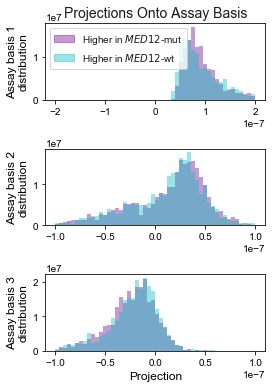

In [18]:
legend_assay_vecs = [mpatches.Patch(color=c, label=l) for c,l in zip([(110/255, 0/255, 140/255, 0.4), (0, 0.75, 0.75, .4)], ['Higher in $\it{MED12}$-mut', 'Higher in $\it{MED12}$-wt'])]

fig = plt.figure(figsize=(4.0,5.5), edgecolor='k')

assay_name = ['H3K27ac', 'H3K4me3', 'H3K4me1']
bound = [2*10**-7, 1*10**-7, 1*10**-7]

for k in range(n_as):
    mean_values = np.mean(np.multiply(proj_ac[1, :, k, :], np.sign(proj_ac[1, :, 0, :])).numpy(), axis=0)
    assay = k
    ax = fig.add_subplot(311+k, frame_on=True)
    hist_u = plt.hist(mean_values[significant_pos_MED12],
                 bins=50, color=(110/255, 0/255, 140/255, 0.4), range=(-bound[k],bound[k]), density=True)
    hist_d = plt.hist(mean_values[significant_neg_MED12],
                 bins=50, color=(0, 0.75, 0.75, .4), range=(-bound[k],bound[k]), density=True)

    if(k == 0):
        plt.title('Projections Onto Assay Basis',fontsize=14)
        ax.legend(handles=legend_assay_vecs,
                       frameon=True, fontsize=10, ncol=1)
        
    ax.set_ylabel('Assay basis ' + str(k+1) + '\ndistribution', fontsize=12)
    if(k == n_as-1):
        ax.set_xlabel('Projection',fontsize=12)
plt.tight_layout()

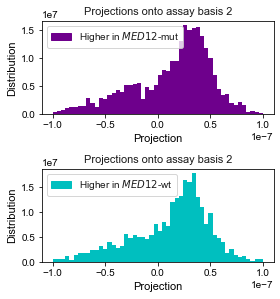

In [19]:
import matplotlib.patches as mpatches
legend_assay_vecs_up = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0.75,0.75,1.0)], ['Higher in $\it{MED12}$-wt'])]
legend_assay_vecs_down = [mpatches.Patch(color=c, label=l) for c,l in zip([(110/255, 0/255, 140/255)], ['Higher in $\it{MED12}$-mut'])]

mean_values = np.mean(np.multiply(proj_ac[1, :, 1, :], np.sign(proj_ac[1, :, 0, :])).numpy(), axis=0)

fig = plt.figure(figsize=(4.0, 4.26), edgecolor='k')

ax = fig.add_subplot(211)

hist_d = plt.hist(mean_values[significant_pos_MED12],
                  bins=50, color=(110/255, 0/255, 140/255, 1.0),
                  range=(-10**-7,10**-7), density=True)

plt.title('Projections onto assay basis 2',fontsize=11)
ax.legend(handles=legend_assay_vecs_down,
                frameon=True, fontsize=10, ncol=1)
        
ax.set_ylabel('Distribution', fontsize=11)

ax.set_xlabel('Projection',fontsize=11)
plt.tight_layout()

ax = fig.add_subplot(212)

hist_u = plt.hist(mean_values[significant_neg_MED12],
                  bins=50, color=(0,0.75,0.75,1.0),
                  range=(-10**-7,10**-7), density=True)

plt.title('Projections onto assay basis 2',fontsize=11)
ax.legend(handles=legend_assay_vecs_up,
                frameon=True, fontsize=10, ncol=1)
        
ax.set_ylabel('Distribution', fontsize=11)

ax.set_xlabel('Projection',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/' + 'figureS6_panels/' + file_prefix +
            '_panelA_assay_basis_2_projection_MED12_distribution_' + date + '.pdf',
             bbox_inches='tight', transparent=True, format='pdf')

(3238, 3)


Text(0.5, 39.39999999999995, 'Tissue sample')

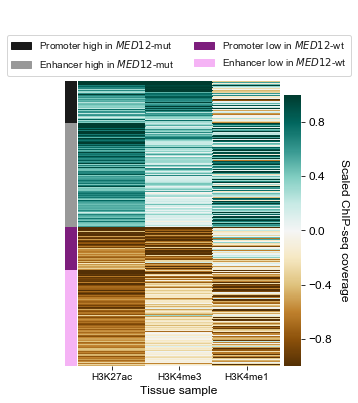

In [20]:
regulatory_colors = ['k', (0.6, 0.6, 0.6), (125/255, 30/255, 125/255),
                     (245/255, 179/255, 245/255)]
regulatory_labels = ['Promoter high in $\it{MED12}$-mut', 'Enhancer high in $\it{MED12}$-mut',
                     'Promoter low in $\it{MED12}$-wt', 'Enhancer low in $\it{MED12}$-wt']
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip(regulatory_colors, regulatory_labels)]

end_regions = np.column_stack((np.mean(t[1,MED12mut_list,0,:].numpy(), axis=0) - np.mean(t[1,MED12wt_list,0,:].numpy(), axis=0),
                               np.mean(t[1,MED12mut_list,1,:].numpy(), axis=0) - np.mean(t[1,MED12wt_list,1,:].numpy(), axis=0),
                               np.mean(t[1,MED12mut_list,2,:].numpy(), axis=0) - np.mean(t[1,MED12wt_list,2,:].numpy(), axis=0)))

end_regions = end_regions[functional_order, :]
end_regions = end_regions - np.mean(end_regions, axis=0)
print(end_regions.shape)
max_scale = [np.percentile(np.abs(end_regions)[:,k], 90, interpolation='nearest') for k in range(3)]
end_regions[:,0] = np.divide(end_regions[:,0], max_scale[0])
end_regions[:,1] = np.divide(end_regions[:,1], max_scale[1])
end_regions[:,2] = np.divide(end_regions[:,2], max_scale[2])

g = seaborn.clustermap(end_regions, row_cluster=False, col_cluster=False, cmap="BrBG",
                       row_colors=functional_color, center = 0.0, vmin = -1.0, vmax= 1.0,
                       xticklabels = ['H3K27ac' , 'H3K4me3', 'H3K4me1'], yticklabels=[],
                       figsize=(4.8, 6.6))

g.ax_row_dendrogram.set_visible(False)

g.cax.set_position([0.91,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=12)
g.cax.set_ylabel('Scaled ChIP-seq coverage', rotation=270, fontsize=12, labelpad=17)

g.ax_heatmap.yaxis.set_label_position("left")

l2=g.ax_heatmap.legend(loc='lower center', bbox_to_anchor=(0.45, 1.0, 0.1, 0.1), handles=legend_TN,
                       frameon=True, fontsize=10, ncol=2)

g.ax_heatmap.set_xlabel('Tissue sample', fontsize=12)

In [21]:
# Write the enhancer and promoter regions in separate bed files

base_line = 0.0 
print(base_line)
mean_values = np.mean(np.multiply(proj_ac[1, :, 1, :], np.sign(proj_ac[1, :, 0, :])).numpy(), axis=0)

    
output_up = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(6+1) + '_MED12_promoter.bed','w+')

for l in range(0,len(significant_pos_MED12)):
    if(mean_values[significant_pos_MED12[l]] < base_line):
        output_up.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos_MED12[l]][0],genomic_bin[significant_pos_MED12[l]][1],genomic_bin[significant_pos_MED12[l]][2]))     
output_up.close()

output_up = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(6+1) + '_MED12_enhancer.bed','w+')

for l in range(0,len(significant_pos_MED12)):
    if(mean_values[significant_pos_MED12[l]] > base_line):
        output_up.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos_MED12[l]][0],genomic_bin[significant_pos_MED12[l]][1],genomic_bin[significant_pos_MED12[l]][2]))     
output_up.close()

full_output_pos = open(output_dir + 'region_files/' + 'location_vector_7_differential_regions_pos.txt', 'w+')
full_output_pos.write("{}\t{}\t{}\t{}\t{}\n".format('chr', 'x1', 'x2', 'component', 'function'))
for l in range(0, len(significant_pos_MED12)):
    full_output_pos.write("{}\t{}\t{}\t{}\t".format(genomic_bin[significant_pos_MED12[l]][0],
                                                    genomic_bin[significant_pos_MED12[l]][1],
                                                    genomic_bin[significant_pos_MED12[l]][2],
                                                    U_l[significant_pos_MED12[l], 6]))
    if(mean_values[significant_pos_MED12[l]] < base_line):
        full_output_pos.write("{}\n".format('promoter'))
    else:
        full_output_pos.write("{}\n".format('enhancer'))
full_output_pos.close()

output_down = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(6+1) + '_MED12_promoter.bed','w+')

for l in range(0,len(significant_neg_MED12)):
    if(mean_values[significant_neg_MED12[l]] < base_line):
        output_down.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg_MED12[l]][0],genomic_bin[significant_neg_MED12[l]][1],genomic_bin[significant_neg_MED12[l]][2]))
output_down.close()

output_down = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(6+1) + '_MED12_enhancer.bed','w+')

for l in range(0,len(significant_neg_MED12)):
    if(mean_values[significant_neg_MED12[l]] > base_line):
        output_down.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg_MED12[l]][0],genomic_bin[significant_neg_MED12[l]][1],genomic_bin[significant_neg_MED12[l]][2]))
output_down.close()

full_output_neg = open(output_dir + 'region_files/' + 'location_vector_7_differential_regions_neg.txt', 'w+')
full_output_neg.write("{}\t{}\t{}\t{}\t{}\n".format('chr', 'x1', 'x2', 'component', 'function'))
for l in range(0, len(significant_neg_MED12)):
    full_output_neg.write("{}\t{}\t{}\t{}\t".format(genomic_bin[significant_neg_MED12[l]][0],
                                                    genomic_bin[significant_neg_MED12[l]][1],
                                                    genomic_bin[significant_neg_MED12[l]][2],
                                                    U_l[significant_neg_MED12[l], 6]))
    if(mean_values[significant_neg_MED12[l]] < base_line):
        full_output_neg.write("{}\n".format('promoter'))
    else:
        full_output_neg.write("{}\n".format('enhancer'))
full_output_neg.close()

0.0


In [22]:
## Distribution around gene transcription start sites ##

In [23]:
# The gene table can be obtained from the UCSC Table Browser.
# Select the knownGene table for the hg19 genome and select the
# first 5 fields for output.
isoform_file = open('./knownGene_hg19.txt','r')
isoform_table = []
for iso in isoform_file:
    if(iso[0] != '#'):
        isoform_table.append(iso.strip().split('\t'))
    
isoform_file.close()

TSS_loc = [[] for c in chr_list]

for i in range(0,len(isoform_table)):
    isoform_table[i][3] = int(isoform_table[i][3])
    isoform_table[i][4] = int(isoform_table[i][4])

gene_table_byChr = [[] for i in range(0,len(chr_list))]
for i in range(len(isoform_table)):
    if(isoform_table[i][1] not in chr_list):
        continue
    gene_table_byChr[chr_list[isoform_table[i][1]]].append(isoform_table[i]) 
    
for c in range(len(chr_list)):
    for i in range(len(gene_table_byChr[c])):
        if(gene_table_byChr[c][i][2] == '+'):
            if(gene_table_byChr[c][i][3] not in TSS_loc[c]):
                TSS_loc[c].append(gene_table_byChr[c][i][3])
        elif(gene_table_byChr[c][i][2] == '-'):
            if(gene_table_byChr[c][i][4] not in TSS_loc[c]):
                TSS_loc[c].append(gene_table_byChr[c][i][4])
        else:
            print("No strand: ", c, i)

In [24]:
def getMinDistance(value, some_list):
    min_d = abs(value - some_list[0])
    for i in range(1,len(some_list)):
        if(abs(value - some_list[i]) < min_d):
            min_d = abs(value - some_list[i])
    return min_d

def getDistribution(data_list, N, lower, upper):
    """Obtain a histogram for the list over a given range.
    
    The region between lower and upper will be binned into
    equally sized bins. There is an additional overflow bin
    that contains the number of elements beyond the upper 
    bound. Elements below the lower bound are thrown out.
    The bin values are scaled to the total number of
    elements in the input data list.
    """
    L = len(data_list)
    distribution = [0.0 for i in range(N+1)]
    step = (upper-lower)/N
    for l in range(L):
        for k in range(N):
            if(data_list[l] >= lower + step*k and data_list[l] < lower + step*(k+1)):
                distribution[k] += 1
                break
            elif(data_list[l] >= upper):
                distribution[-1] += 1
                break
    for k in range(N+1):
        distribution[k] /= L
    return distribution

In [25]:
# Get the minimum distance between each enhancer region lower in leio and the
# nearest gene TSS. Then get the distribution of these regions for plotting.
region_pos_enhancers = abf.readBed('../region_files/' + file_prefix + '_pos_loc4_enhancer.bed')
distance_list_pos_enhancers = []

for c in range(len(chr_list)):
    for i in range(len(region_pos_enhancers[c])):
        distance_list_pos_enhancers.append(getMinDistance(0.5*(region_pos_enhancers[c][i][2] + region_pos_enhancers[c][i][1]), TSS_loc[c]))
        
print("Max distance: ", max(distance_list_pos_enhancers))
N = 10
upper_enhancer = 200000
distance_distribution_pos_enhancers =  getDistribution(distance_list_pos_enhancers, N, 0, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_pos_enhancers))
print("Median distance: ", np.median(distance_list_pos_enhancers))

Max distance:  405674.0
Mean distance:  29271.202150537636
Median distance:  13263.0


In [26]:
# Get the minimum distance between each promoter region lower in leio and the
# nearest gene TSS. Then get the distribution of these regions for plotting.
region_pos_promoters = abf.readBed('../region_files/' + file_prefix + '_pos_loc4_promoter.bed')
distance_list_pos_promoters = []

for c in range(len(chr_list)):
    for i in range(len(region_pos_promoters[c])):
        distance_list_pos_promoters.append(getMinDistance(0.5*(region_pos_promoters[c][i][2] + region_pos_promoters[c][i][1]), TSS_loc[c]))

print("Max distance: ", max(distance_list_pos_promoters))
N = 10
upper_promoter = 200000 #10000
distance_distribution_pos_promoters =  getDistribution(distance_list_pos_promoters,N, 0, upper_promoter)     
print("Mean distance: ", np.mean(distance_list_pos_promoters))
print("Median distance: ", np.median(distance_list_pos_promoters))

Max distance:  236679.0
Mean distance:  7467.795212765957
Median distance:  1681.5


In [27]:
# Get the minimum distance between each enhancer region higher in leio and the
# nearest gene TSS. Then get the distribution of these regions for plotting.
region_neg_enhancers = abf.readBed('../region_files/' + file_prefix + '_neg_loc4_enhancer.bed')
distance_list_neg_enhancers = []

for c in range(len(chr_list)):
    for i in range(len(region_neg_enhancers[c])):
        distance_list_neg_enhancers.append(getMinDistance(0.5*(region_neg_enhancers[c][i][2] + region_neg_enhancers[c][i][1]), TSS_loc[c]))

print("Max distance: ", max(distance_list_neg_enhancers))
N = 10
upper_enhancer = 200000
distance_distribution_neg_enhancers =  getDistribution(distance_list_neg_enhancers, N, 0, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_neg_enhancers))
print("Median distance: ", np.median(distance_list_neg_enhancers))

Max distance:  1094234.0
Mean distance:  82060.44012688342
Median distance:  43062.0


In [28]:
# Get the minimum distance between each promoter region higher in leio and the
# nearest gene TSS. Then get the distribution of these regions for plotting.
region_neg_promoters = abf.readBed('../region_files/' + file_prefix + '_neg_loc4_promoter.bed')
distance_list_neg_promoters = []

for c in range(len(chr_list)):
    for i in range(len(region_neg_promoters[c])):
        distance_list_neg_promoters.append(getMinDistance(0.5*(region_neg_promoters[c][i][2] + region_neg_promoters[c][i][1]), TSS_loc[c]))

print("Max distance: ", max(distance_list_neg_promoters))
N = 10
upper_promoter = 200000 #10000
distance_distribution_neg_promoters =  getDistribution(distance_list_neg_promoters, N, 0, upper_promoter)     
print("Mean distance: ", np.mean(distance_list_neg_promoters))
print("Median distance: ", np.median(distance_list_neg_promoters))

Max distance:  896051.0
Mean distance:  13185.159784560143
Median distance:  2142.0


In [29]:
scipy.stats.mannwhitneyu(distance_list_neg_enhancers, distance_list_pos_enhancers)

MannwhitneyuResult(statistic=387960.0, pvalue=3.664057892811543e-42)

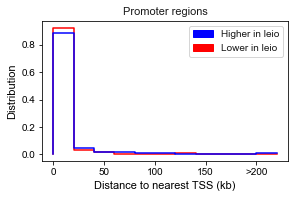

In [30]:
# Figure 3C distribution of differential promoters around nearest gene TSS
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (1,0,0,1)], ['Higher in leio', 'Lower in leio'])]
fig1 = plt.figure(1,figsize=(4.2, 2.85))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_promoter/N) for i in range(len(distance_distribution_pos_promoters)+1)],
         [0] + distance_distribution_pos_promoters,
         c=(1,0,0,1), ds='steps')
ax1.plot([i*(upper_promoter/N) for i in range(len(distance_distribution_neg_promoters)+1)],
         [0] + distance_distribution_neg_promoters,
         c=(0,0,1,1), ds='steps')

a=ax1.get_xticks().tolist()
#a[-2]='>10'
a[-2]='>200'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest TSS (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Promoter regions',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + '/figures/figure3_panels/TSS_distance_distribution_promoters' + date + '.pdf',
            transparent=True, format='pdf')

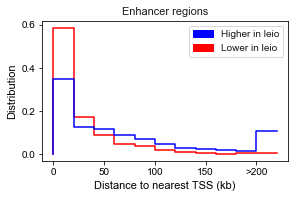

In [31]:
# Figure 3D distribution of differential enhancers around nearest gene TSS
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0,0,1,1), (1,0,0,1)], ['Higher in leio', 'Lower in leio'])]
fig2 = plt.figure(1, figsize=(4.2, 2.85))
ax2 = fig2.add_subplot(111)  
fig2.canvas.draw()

ax2.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_pos_enhancers)+1)],
         [0] + distance_distribution_pos_enhancers,
         c=(1,0,0,1), ds='steps')
ax2.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_neg_enhancers)+1)],
         [0] + distance_distribution_neg_enhancers,
         c=(0,0,1,1), ds='steps')

a=ax2.get_xticks().tolist()
a[-2]='>200'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax2.set_xticklabels(a)
ax2.set_xlabel('Distance to nearest TSS (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax2.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax2.set_ylabel('Distribution',fontsize=11)
plt.title('Enhancer regions',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/figure3_panels/TSS_distance_distribution_enhancers' + date + '.pdf',
            transparent=True, format='pdf')

In [32]:
# Get the minimum distance between each enhancer region higher in MED12mut leio
# and the nearest gene TSS. Then get the distribution of these regions for plotting.
region_pos_MED12_enhancers = abf.readBed('../region_files/' + file_prefix + '_pos_loc7_MED12_enhancer.bed')
distance_list_pos_MED12_enhancers = []

for c in range(len(chr_list)):
    for i in range(len(region_pos_MED12_enhancers[c])):
        distance_list_pos_MED12_enhancers.append(getMinDistance(0.5*(region_pos_MED12_enhancers[c][i][2] + region_pos_MED12_enhancers[c][i][1]), TSS_loc[c]))

print("Max distance: ", max(distance_list_pos_MED12_enhancers))
N = 10
upper_enhancer = 200000
distance_distribution_pos_MED12_enhancers =  getDistribution(distance_list_pos_MED12_enhancers, N, 0, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_pos_MED12_enhancers))
print("Median distance: ", np.median(distance_list_pos_MED12_enhancers))

Max distance:  828553.0
Mean distance:  55228.92753623189
Median distance:  30233.0


In [33]:
# Get the minimum distance between each promoter region higher in MED12mut leio
# and the nearest gene TSS. Then get the distribution of these regions for plotting.
region_pos_MED12_promoters = abf.readBed('../region_files/' + file_prefix + '_pos_loc7_MED12_promoter.bed')
distance_list_pos_MED12_promoters = []

for c in range(len(chr_list)):
    for i in range(len(region_pos_MED12_promoters[c])):
        distance_list_pos_MED12_promoters.append(getMinDistance(0.5*(region_pos_MED12_promoters[c][i][2] + region_pos_MED12_promoters[c][i][1]), TSS_loc[c]))

print("Max distance: ", max(distance_list_pos_MED12_promoters))
N = 10
upper_promoter = 200000 #10000
distance_distribution_pos_MED12_promoters =  getDistribution(distance_list_pos_MED12_promoters,N, 0, upper_promoter)     
print("Mean distance: ", np.mean(distance_list_pos_MED12_promoters))
print("Median distance: ", np.median(distance_list_pos_MED12_promoters))

Max distance:  762555.0
Mean distance:  14021.952965235174
Median distance:  1756.0


In [34]:
# Get the minimum distance between each enhancer region higher in MED12wt leio
# and the nearest gene TSS. Then get the distribution of these regions for plotting.
region_neg_MED12_enhancers = abf.readBed('../region_files/' + file_prefix + '_neg_loc7_MED12_enhancer.bed')
distance_list_neg_MED12_enhancers = []

for c in range(len(chr_list)):
    for i in range(len(region_neg_MED12_enhancers[c])):
        distance_list_neg_MED12_enhancers.append(getMinDistance(0.5*(region_neg_MED12_enhancers[c][i][2] + region_neg_MED12_enhancers[c][i][1]), TSS_loc[c]))

print("Max distance: ", max(distance_list_neg_MED12_enhancers))
N = 10
upper_enhancer = 200000
distance_distribution_neg_MED12_enhancers =  getDistribution(distance_list_neg_MED12_enhancers, N, 0, upper_enhancer)     
print("Mean distance: ", np.mean(distance_list_neg_MED12_enhancers))
print("Median distance: ", np.median(distance_list_neg_MED12_enhancers))

Max distance:  779050.0
Mean distance:  55741.40997229917
Median distance:  30148.0


In [35]:
# Get the minimum distance between each promoter region higher in MED12wt leio
# and the nearest gene TSS. Then get the distribution of these regions for plotting.
region_neg_MED12_promoters = abf.readBed('../region_files/' + file_prefix + '_neg_loc7_MED12_promoter.bed')
distance_list_neg_MED12_promoters = []

for c in range(len(chr_list)):
    for i in range(len(region_neg_MED12_promoters[c])):
        distance_list_neg_MED12_promoters.append(getMinDistance(0.5*(region_neg_MED12_promoters[c][i][2] + region_neg_MED12_promoters[c][i][1]), TSS_loc[c]))

print("Max distance: ", max(distance_list_neg_MED12_promoters))
N = 10
upper_promoter = 200000 #10000
distance_distribution_neg_MED12_promoters =  getDistribution(distance_list_neg_MED12_promoters, N, 0, upper_promoter)     
print("Mean distance: ", np.mean(distance_list_neg_MED12_promoters))
print("Median distance: ", np.median(distance_list_neg_MED12_promoters))

Max distance:  394194.0
Mean distance:  12856.281947261663
Median distance:  1985.0


In [36]:
scipy.stats.mannwhitneyu(distance_list_neg_MED12_enhancers,
                         distance_list_pos_MED12_enhancers)

MannwhitneyuResult(statistic=627845.5, pvalue=0.31759635370529404)

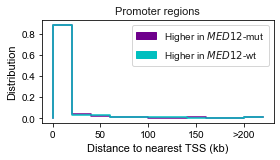

In [37]:
# Figure S4B distribution of subtype differential promoters around nearest gene TSS
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(110/255, 0/255, 140/255, 1), (0,0.75,0.75,1)], ['Higher in $\it{MED12}$-mut', 'Higher in $\it{MED12}$-wt'])]
fig1 = plt.figure(1,figsize=(4.0,2.335))
ax1 = fig1.add_subplot(111)  
fig1.canvas.draw()

ax1.plot([i*(upper_promoter/N) for i in range(len(distance_distribution_pos_MED12_promoters)+1)],
         [0] + distance_distribution_pos_MED12_promoters,
         c=(110/255, 0/255, 140/255, 1), ds='steps')
ax1.plot([i*(upper_promoter/N) for i in range(len(distance_distribution_neg_MED12_promoters)+1)],
         [0] + distance_distribution_neg_MED12_promoters,
         c=(0, 0.75, 0.75, 1), ds='steps')

a=ax1.get_xticks().tolist()
a[-2]='>200' #'>10'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax1.set_xticklabels(a)
ax1.set_xlabel('Distance to nearest TSS (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax1.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax1.set_ylabel('Distribution',fontsize=11)
plt.title('Promoter regions',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/figureS6_panels/TSS_distance_distribution_MED12_promoters' + date + '.pdf',
            transparent=True, format='pdf')

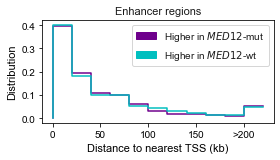

In [38]:
# Figure S4C distribution of subtype differential promoters around nearest gene TSS
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(110/255, 0/255, 140/255,1), (0,0.75,0.75,1)], ['Higher in $\it{MED12}$-mut', 'Higher in $\it{MED12}$-wt'])]
fig2 = plt.figure(2,figsize=(4.0,2.335))
ax2 = fig2.add_subplot(111)  
fig2.canvas.draw()

ax2.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_pos_MED12_enhancers)+1)],
         [0] + distance_distribution_pos_MED12_enhancers,
         c=(110/255, 0/255, 140/255,1), ds='steps')
ax2.plot([i*(upper_enhancer/N) for i in range(len(distance_distribution_neg_MED12_enhancers)+1)],
         [0] + distance_distribution_neg_MED12_enhancers,
         c=(0,0.75,0.75,1), ds='steps')

a=ax2.get_xticks().tolist()
a[-2]='>200'
for i in range(len(a)-2):
    a[i] = int(int(a[i])/1000)
ax2.set_xticklabels(a)
ax2.set_xlabel('Distance to nearest TSS (kb)',fontsize=11)
#plt.ylim(0.0, 0.6)

ax2.legend(handles=legend_TN, frameon=True, fontsize=10, ncol=1)

ax2.set_ylabel('Distribution',fontsize=11)
plt.title('Enhancer regions',fontsize=11)
plt.tight_layout()

plt.savefig(output_dir + 'figures/figureS6_panels/TSS_distance_distribution_MED12_enhancers' + date + '.pdf',
            transparent=True, format='pdf')